# MNIST2 results

#### Imports

In [1]:
from helpers import calc_fuzziness, load_mnist, test_loss_func, generate_results_df, calc_error_rates, generate_distance_metrics, calc_efficiency_metrics, savefig
from model import FFNN, FFNNAdapter

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
np.random.seed(500)
import pandas as pd
import pickle
import seaborn as sns
sns.set(context='notebook', style="whitegrid", font='serif', font_scale=1, color_codes=True, rc=None)
from sklearn.model_selection import train_test_split
import time
import os

import nonconformist
from nonconformist.acp import AggregatedCp, RandomSubSampler
from nonconformist.icp import IcpClassifier
from nonconformist.nc import  ClassifierNc

#### ```IS_LOAD_RESULTS = True``` shows the results presented in the paper. To generate new results, change value to ```False```

Note that depending on the available processing power, generating new results may take some time because of a gridsearch.

In [2]:
IS_LOAD_RESULTS = True
IS_SAVE_GRAPHS = False

DATASET = "MNIST-2"
N_CLASS = 2

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [3]:
X_train, y_train, X_test, y_test = load_mnist()

print("X_train:", X_train.shape, "y_train:", y_train.shape)

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

X_train: (60000, 28, 28, 1) y_train: (60000,)
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


In [4]:
print("X_test:", X_test.shape, "y_test:", y_test.shape)

unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

X_test: (10000, 28, 28, 1) y_test: (10000,)
[[   0  980]
 [   1 1135]
 [   2 1032]
 [   3 1010]
 [   4  982]
 [   5  892]
 [   6  958]
 [   7 1028]
 [   8  974]
 [   9 1009]]


In [5]:
X_train, y_train, X_test, y_test = load_mnist()

unique, counts = np.unique(np.hstack((y_train, y_test)), return_counts=True)
print(np.asarray((unique, counts)).T)

train_mask = np.logical_or(y_train==0, y_train==1)
test_mask = np.logical_or(y_test==0, y_test==1)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print("\nX_train:", X_train.shape, "y_train:", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print("\nX_test:", X_test.shape, "y_test:", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 6903]
 [   1 7877]
 [   2 6990]
 [   3 7141]
 [   4 6824]
 [   5 6313]
 [   6 6876]
 [   7 7293]
 [   8 6825]
 [   9 6958]]

X_train: (12665, 28, 28, 1) y_train: (12665,)
[[   0 5923]
 [   1 6742]]

X_test: (2115, 28, 28, 1) y_test: (2115,)
[[   0  980]
 [   1 1135]]


In [6]:
b = np.bincount(y_train)
print("TRAIN: ", {v:c for v, c in zip(np.unique(y_train), b[np.unique(y_train)]/len(y_train)*100)})

b = np.bincount(y_test)
print("TEST: ", {v:c for v, c in zip(np.unique(y_test), b[np.unique(y_test)]/len(y_test)*100)})

TRAIN:  {0: 46.766679826292936, 1: 53.233320173707064}
TEST:  {0: 46.335697399527184, 1: 53.664302600472816}


## Feedforward Neural Network

In [7]:
batch_size = 128
input_shape = X_train.shape[1:]

### Standard probailistic classification
Testing whether the model architecture is complex enough to model the relationship between sample input and expected label.

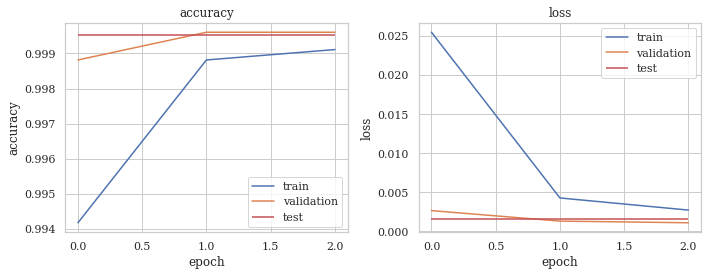

In [8]:
ffnn = FFNN(X_train.shape[1:], 2, a2='sigmoid') \
            .fit(X_train, y_train)

test_loss_ffnn, test_acc_ffnn = ffnn.eval_graph(X_test, y_test)

## Conformal loss function
Approximates standard two-step Conformal Prediction in one step. By measuring the distance of the DL model output distribution with that expected by CP, we may teach a neural network the direct relationship between data input and conformal p-values.

In [9]:
def conformal_loss(y_true, y_pred):
    # parameters for gridsearch
    global weight_l2
    global weight_huber
    global delta_huber
    global weight_var
    global weight_mean
    global weight_positive
    global weight_negative

    # label formatting
    y_onehot = tf.one_hot(tf.reshape(y_true, [-1]), depth=N_CLASS)
    true_mask = tf.cast(y_onehot, tf.bool)
    false_mask = tf.math.logical_not(true_mask)
    y_pred_true = tf.reshape(tf.boolean_mask(y_pred, true_mask, axis=0), [-1, 1])
    y_pred_false = tf.reshape(tf.boolean_mask(y_pred, false_mask, axis=0), [-1, N_CLASS-1])
    
    # evaluating false-class p-values (should be minimised to 0 for optimal predictive efficiency)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss_false = bce(tf.zeros_like(y_pred_false), y_pred_false)

    # evaluating true-class p-values (should be approximately uniformly distributed for
    # approximate validity, i.e. guaranteed maximum error rate)
    loss_l2 = tf.nn.l2_loss(y_pred_true/tf.reduce_sum(y_pred_true))
    loss_mean = tf.math.sqrt(tf.math.square(tf.reduce_mean(y_pred_true)-0.5))
    loss_var = tf.math.sqrt(tf.math.square(tf.math.reduce_variance(y_pred_true)-1/12))
    loss_huber = -tf.keras.losses.Huber(delta=delta_huber)(tf.fill(tf.shape(y_pred_true), 0.55), y_pred_true) 
    loss_true = weight_l2*loss_l2 + weight_huber*loss_huber + weight_mean*loss_mean + weight_var*loss_var 

    # total loss
    return weight_positive*loss_true + weight_negative*loss_false

In [10]:
if IS_LOAD_RESULTS:  # load results used in paper
    df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))

else:  # generate results, identify optimal loss parameters with a gridsearch
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    print("Results saving to: {}".format(SAVE_DIR))
    
    weight_positive = 1
    weight_negative = 1

    for weight_l2 in [5, 4, 3, 2, 1, 0]:
        for weight_huber in [0.25]:
            for delta_huber in [0.125]:
                for weight_var in [1]:
                    for weight_mean in [1]:
                            model = FFNN(input_shape, N_CLASS, loss=conformal_loss)
                            _, _ = test_loss_func(N_CLASS, model, X_train, y_train, X_test, y_test, batch_size, \
                                                  "FFNN conformal loss l2-{} hw-{} hd-{} v-{} m-{} p-{} n-{}".format(weight_l2, \
                                                  weight_huber, delta_huber, weight_var, weight_mean, weight_positive, weight_negative), SAVE_DIR)
    df_ffnn = generate_results_df('FFNN', DATASET, SAVE_DIR, y_test)

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [11]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.093810e-30,0.979196,0.05,FFNN,3.718966,0.177764,0.128040,MNIST-2,./pickles/MNIST-2 intermediate results/0 - FFN...,1.262884
1,1,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.067491e-25,0.939007,0.05,FFNN,3.047652,0.163213,0.116373,MNIST-2,./pickles/MNIST-2 intermediate results/1 - FFN...,0.752955
2,2,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.349845e-35,0.985816,0.05,FFNN,3.843186,0.143845,0.136443,MNIST-2,./pickles/MNIST-2 intermediate results/2 - FFN...,1.249409
3,3,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243407e-20,0.964066,0.05,FFNN,4.341715,0.249414,0.104676,MNIST-2,./pickles/MNIST-2 intermediate results/3 - FFN...,1.019858
4,4,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.006426e-40,0.955556,0.05,FFNN,3.554470,0.170560,0.146023,MNIST-2,./pickles/MNIST-2 intermediate results/4 - FFN...,0.920331
5,5,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.611605e-32,0.980615,0.05,FFNN,2.960725,0.159360,0.131416,MNIST-2,./pickles/MNIST-2 intermediate results/5 - FFN...,1.025768
6,6,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,6.017028e-32,0.980142,0.05,FFNN,2.475206,0.116308,0.130669,MNIST-2,./pickles/MNIST-2 intermediate results/6 - FFN...,1.100709
7,7,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.000476e-32,0.986288,0.05,FFNN,4.015790,0.121749,0.132269,MNIST-2,./pickles/MNIST-2 intermediate results/7 - FFN...,1.270449
8,8,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.213406e-46,0.988652,0.05,FFNN,5.125406,0.093151,0.157653,MNIST-2,./pickles/MNIST-2 intermediate results/8 - FFN...,1.276123
9,9,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243964e-31,0.981087,0.05,FFNN,3.289945,0.143222,0.130016,MNIST-2,./pickles/MNIST-2 intermediate results/9 - FFN...,1.208511


## Identify optimal loss function parameters
Measured by checking the miscalibration rate (i.e., the output distribution of the true p-values). Smaller values are preferred.

In [12]:
top30 = df_ffnn.sort_values('abs_calib_distance', ascending=True).head(30)
# print(top30)
top30_medianKsPvalues = top30.groupby("loss")['abs_calib_distance'].median()
print(top30_medianKsPvalues)
loss_options = df_ffnn[df_ffnn.loss.isin(top30_medianKsPvalues.index)].groupby("loss")['abs_calib_distance'].mean().sort_values(ascending=True)

print(loss_options)

best_loss = str(loss_options.index[0])
print("\nBEST LOSS PARAMS: ", best_loss)

loss
FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 m-1.pickle    1.15461
Name: abs_calib_distance, dtype: float64
loss
FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 m-1.pickle    1.1087
Name: abs_calib_distance, dtype: float64

BEST LOSS PARAMS:  FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 m-1.pickle


In [13]:
df_ffnn_best = df_ffnn.query("loss==@best_loss")
df_ffnn_best

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.093810e-30,0.979196,0.05,FFNN,3.718966,0.177764,0.128040,MNIST-2,./pickles/MNIST-2 intermediate results/0 - FFN...,1.262884
1,1,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.067491e-25,0.939007,0.05,FFNN,3.047652,0.163213,0.116373,MNIST-2,./pickles/MNIST-2 intermediate results/1 - FFN...,0.752955
2,2,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.349845e-35,0.985816,0.05,FFNN,3.843186,0.143845,0.136443,MNIST-2,./pickles/MNIST-2 intermediate results/2 - FFN...,1.249409
3,3,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243407e-20,0.964066,0.05,FFNN,4.341715,0.249414,0.104676,MNIST-2,./pickles/MNIST-2 intermediate results/3 - FFN...,1.019858
4,4,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.006426e-40,0.955556,0.05,FFNN,3.554470,0.170560,0.146023,MNIST-2,./pickles/MNIST-2 intermediate results/4 - FFN...,0.920331
5,5,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.611605e-32,0.980615,0.05,FFNN,2.960725,0.159360,0.131416,MNIST-2,./pickles/MNIST-2 intermediate results/5 - FFN...,1.025768
6,6,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,6.017028e-32,0.980142,0.05,FFNN,2.475206,0.116308,0.130669,MNIST-2,./pickles/MNIST-2 intermediate results/6 - FFN...,1.100709
7,7,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.000476e-32,0.986288,0.05,FFNN,4.015790,0.121749,0.132269,MNIST-2,./pickles/MNIST-2 intermediate results/7 - FFN...,1.270449
8,8,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.213406e-46,0.988652,0.05,FFNN,5.125406,0.093151,0.157653,MNIST-2,./pickles/MNIST-2 intermediate results/8 - FFN...,1.276123
9,9,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243964e-31,0.981087,0.05,FFNN,3.289945,0.143222,0.130016,MNIST-2,./pickles/MNIST-2 intermediate results/9 - FFN...,1.208511


# Aggregated Conformal Prediction (ACP)
Split the training set into a training proper and calibration set for the computationally efficiency inductive variant. To have the closest comparison, we use the same FFNN model and our conformal loss function as the underlying model.


**Read below if you would like to generate your own ACP results (i.e. ```IS_LOAD_RESULTS=False```), otherwise ignore.**

_The nonconformist package for ACP is not officially compatible with Python 3 or tensorflow models. Please make the following changes, filling in values for \<placeholders\>:_ (works as of 30/12/2022)
1. Open the file ~/anaconda3/envs/\<env-name\>/lib/python3.9/site-packages/nonconformist/acp.py. (file path might be different if you're using a different environment manager)
2. In lines 10 and 11, update the lines ```from sklearn.cross_validation import ...``` to ```from sklearn.model_selection import ...```
3. In line 78, comment out the entire ```def gen_samples(self, y, n_samples, problem_type): ...``` function, and replace with

```
def gen_samples(self, y, n_samples, problem_type):
    if problem_type == 'classification':
        splitter = StratifiedShuffleSplit(n_splits=n_samples,
                                       test_size=self.cal_portion)
        splits = splitter.split(y, y) # 'X' is ignored, but checked for length
    else:
        print("NOT compatible for regression")

    for train, cal in splits:
        yield train, cal
```
4. Add these two lines to the import section:
```
import tensorflow as tf
from tensorflow.keras.models import clone_model
```
5. After line ```predictor = clone(self.predictor)``` (196 in the AggregatedCp function ```def fit(self, x, y): ...```), include:
```
predictor.nc_function.model.model.model = clone_model(self.predictor.nc_function.model.model.model)
predictor.nc_function.model.model.model.compile(optimizer='adam',
      loss = predictor.nc_function.model.model.loss,
      metrics=['accuracy'])
```

In [14]:
X_train_prop, X_calib, y_train_prop, y_calib = train_test_split(X_train, y_train, test_size=1./3., random_state=42)

In [15]:
if IS_LOAD_RESULTS:  # load results used in paper
    df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))
    
else:  # generate new results (see instructions under 'Aggregated Conformal Prediction' header)
    print("Results saving to: {}".format(SAVE_DIR))
    for i in range(1, 11):
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        print("Training for ACP with n={} started".format(i))

        filename = "{}/{} - ACP".format(SAVE_DIR, i)
        acp_fnn = AggregatedCp(IcpClassifier(ClassifierNc(FFNNAdapter(FFNN(input_shape, N_CLASS, a2='sigmoid', loss=conformal_loss)))), RandomSubSampler(), n_models=i)

        acp_time_train_start_fnn = time.time()
        acp_fnn.fit(X_train, y_train)
        acp_time_train_end_fnn = time.time()
        acp_pvalues_train_fnn = acp_fnn.predict(X_test)

        acp_time_test_start_fnn = time.time()
        acp_pvalues_test_fnn = acp_fnn.predict(X_test)
        acp_time_test_end_fnn = time.time()

        iter_results = {'durations': {'train': acp_time_train_end_fnn-acp_time_train_start_fnn,
                                      'test': acp_time_test_end_fnn-acp_time_test_start_fnn},
                            'pvalues':   {'train': acp_pvalues_train_fnn, 'test': acp_pvalues_test_fnn},
                            'losses': None}
        pickle.dump(iter_results, open(filename+".pickle", 'wb'))
        print("ACP with n={} saved to {}".format(i, filename))

    df_acp = generate_results_df('ACP', DATASET, SAVE_DIR, y_test)
    
df_acp = df_acp.sort_values('iter', ascending=True)

The DataFrame columns are as follows:

- ```iter```: Number of ensemble models for ACP (0 <= ```iter``` <=10).
- ```loss```: Not given for ACP.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The underlying model for ACP, see class ```FFNNAdapter``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [16]:
df_acp

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,1,ACP.pickle,9.551181e-02,0.963121,0.05,FFNN,3.461906,0.627876,0.026736,MNIST-2,./pickles/MNIST-2 intermediate results/1 - ACP...,0.344444
2,2,ACP.pickle,1.636114e-06,0.962175,0.05,FFNN,8.995863,2.569911,0.057467,MNIST-2,./pickles/MNIST-2 intermediate results/2 - ACP...,0.431442
3,3,ACP.pickle,8.705165e-54,0.975887,0.05,FFNN,11.008960,1.894581,0.169810,MNIST-2,./pickles/MNIST-2 intermediate results/3 - ACP...,1.972340
4,4,ACP.pickle,4.580035e-56,0.975414,0.05,FFNN,13.575046,3.093303,0.173376,MNIST-2,./pickles/MNIST-2 intermediate results/4 - ACP...,2.089835
5,5,ACP.pickle,7.485144e-58,0.977305,0.05,FFNN,18.895204,3.314333,0.176119,MNIST-2,./pickles/MNIST-2 intermediate results/5 - ACP...,2.150355
6,6,ACP.pickle,1.299872e-71,0.980142,0.05,FFNN,15.065170,2.970286,0.195931,MNIST-2,./pickles/MNIST-2 intermediate results/6 - ACP...,2.378251
7,7,ACP.pickle,1.833503e-141,0.981087,0.05,FFNN,17.840156,4.114154,0.274626,MNIST-2,./pickles/MNIST-2 intermediate results/7 - ACP...,2.742080
8,8,ACP.pickle,3.045701e-139,0.979669,0.05,FFNN,23.805764,4.532740,0.272493,MNIST-2,./pickles/MNIST-2 intermediate results/8 - ACP...,2.800236
9,9,ACP.pickle,2.361949e-91,0.979196,0.05,FFNN,26.825593,4.405970,0.221178,MNIST-2,./pickles/MNIST-2 intermediate results/9 - ACP...,2.292435
1,10,ACP.pickle,5.428672e-39,0.974468,0.05,FFNN,26.963113,5.744297,0.144481,MNIST-2,./pickles/MNIST-2 intermediate results/10 - AC...,1.683688


# Empirical results

In [17]:
colors = sns.color_palette()

### Calibration

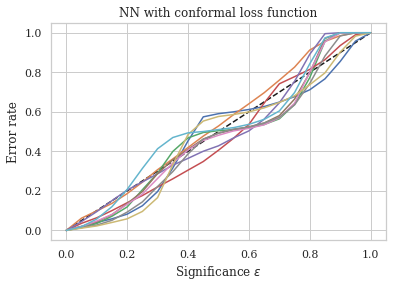

In [18]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn_best.index:
    filepath = df_ffnn_best.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

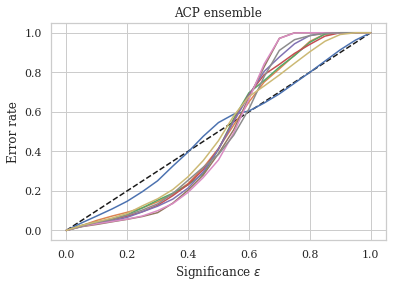

In [19]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()

### Approximate validity

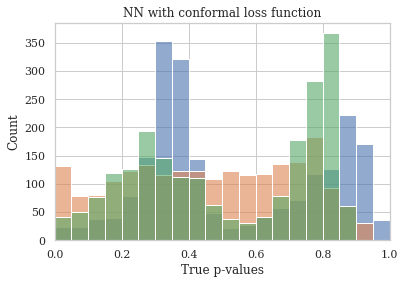

In [20]:
np.random.seed(42)
j = 0
fig = plt.figure(figsize=(6, 4))

for i in np.random.choice(range(0, 10), 3, replace=False):
    filepath = df_ffnn_best.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    true_p_values = results['pvalues']['test'][np.arange(y_test.shape[0]), y_test]
    
    sns.histplot(true_p_values, binrange=(0, 1), bins=20, color=colors[j], alpha=0.6)
    j = j+1
    
plt.xlabel("True p-values")
plt.xlim(0, 1)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_true_pvalues"))

plt.title("NN with conformal loss function")

plt.show()

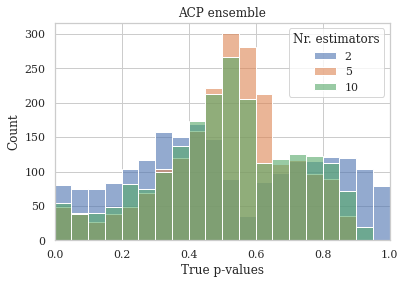

In [21]:
fig = plt.figure(figsize=(6, 4))
j = 0

for i in [2, 5, 10]:
    filepath = df_acp.query("iter==@i").filepath.values[0]    
    results = pickle.load(open(filepath, 'rb'))
    true_p_values = results['pvalues']['test'][np.arange(y_test.shape[0]), y_test]
    
    sns.histplot(true_p_values, label=str(i), binrange=(0, 1), bins=20, color=colors[j], alpha=0.6)
    j = j+1
    
plt.xlabel("True p-values")
plt.xlim(0, 1)
plt.legend(title="Nr. estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_true_pvalues"))

plt.title("ACP ensemble")

plt.show()

### False p-value distribution

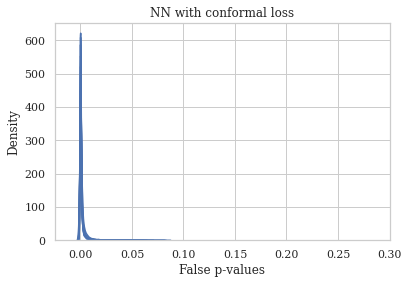

In [22]:
fig = plt.figure(figsize=(6, 4))

for i in df_ffnn_best.index:
    filepath = df_ffnn_best.loc[i].filepath
    results = pickle.load(open(filepath, 'rb'))

    true_indx = np.full_like(results['pvalues']['test'], False, dtype=bool)
    true_indx[np.arange(y_test.shape[0]), y_test] = True
    false_p_hat = results['pvalues']['test'][np.invert(true_indx)]
    
    sns.kdeplot(false_p_hat, color='b')
    
plt.xlabel("False p-values")
plt.xlim(-0.025, 0.3)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_false_pvalues"))

plt.title("NN with conformal loss")

plt.show()

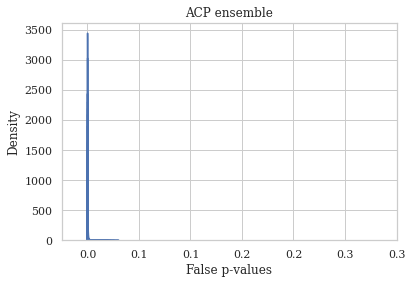

In [23]:
fig = plt.figure(figsize=(6, 4))

for i in range(1, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]    
    results = pickle.load(open(filepath, 'rb'))

    true_indx = np.full_like(results['pvalues']['test'], False, dtype=bool)
    true_indx[np.arange(y_test.shape[0]), y_test] = True
    false_p_hat = results['pvalues']['test'][np.invert(true_indx)]
    
    sns.kdeplot(false_p_hat, color='b')
plt.xlabel("False p-values")
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.xlim(-0.025, 0.3)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_false_pvalues"))

plt.title("ACP ensemble")

plt.show()

### Calibration vs predictive efficiency trade-off

In [24]:
eval_df_nn, dists_nn, avgs_nn = generate_distance_metrics(df_ffnn_best, y_test)
eval_df_acp, dists_acp, avgs_acp = generate_distance_metrics(df_acp, y_test)

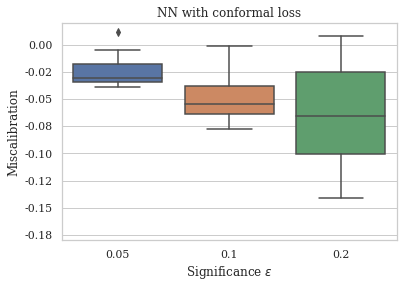

In [25]:
fig = plt.figure()
temp_df = pd.DataFrame(columns=['dist', 'eps'])
temp_df.dist = dists_nn.flatten('F')
temp_df.eps = np.repeat([0.05, 0.1, 0.2], 10)

sns.boxplot(y='dist', x='eps', data=temp_df)
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Miscalibration")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(-0.18, 0.02)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_err_dist_trend"))

plt.title("NN with conformal loss")

plt.show()

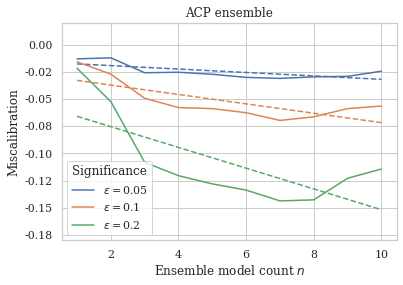

In [26]:
fig = plt.figure()
j = 0
for i, e in enumerate([1, 2, 4]):
    sns.lineplot(x=range(1, 11), y=dists_acp[:, i], label="$\epsilon=$"+str(EPSILON[e]))

    z = np.polyfit(range(1, 11), dists_acp[:, i], 1)
    p = np.poly1d(z)
    plt.plot(range(1, 11), p(range(1, 11)), linestyle="--", color=colors[j])
    j = j+1

plt.legend(title="Significance")
plt.xlabel("Ensemble model count $n$")
plt.ylabel("Miscalibration")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(-0.18, 0.02)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_err_dist_trend"))

plt.title("ACP ensemble")

plt.show()

### Average prediction set size

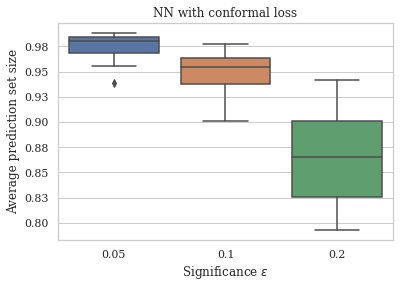

In [27]:
fig = plt.figure()
temp_df = pd.DataFrame(columns=['avg', 'eps'])
temp_df.avg = avgs_nn.flatten('F')
temp_df.eps = np.repeat([0.05, 0.1, 0.2], 10)

sns.boxplot(y='avg', x='eps', data=temp_df)
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Average prediction set size")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_set_size_trend"))

plt.title("NN with conformal loss")

plt.show()

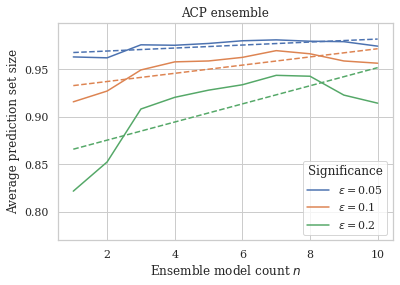

In [28]:
fig = plt.figure()
j = 0
for i, e in enumerate([1, 2, 4]):
    sns.lineplot(x=range(1, 11), y=avgs_acp[:, i], label="$\epsilon=$"+str(EPSILON[e]))

    z = np.polyfit(range(1, 11), avgs_acp[:, i], 1)
    p = np.poly1d(z)
    plt.plot(range(1, 11), p(range(1, 11)), linestyle="--", color=colors[j])
    j = j+1

plt.legend(title="Significance")
plt.xlabel("Ensemble model count $n$")
plt.ylabel("Average prediction set size")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(0.77, 0.999)

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_set_size_trend"))

plt.title("ACP ensemble")

plt.show()

### Training time

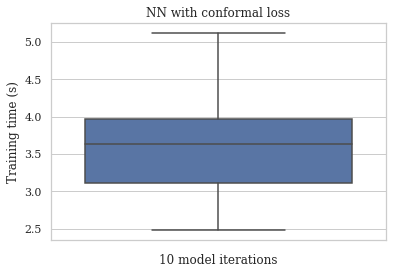

In [29]:
fig = plt.figure()
sns.boxplot(y='time_train', data=df_ffnn_best)

plt.ylabel("Training time (s)")
plt.xlabel("10 model iterations")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_training_time"))

plt.title("NN with conformal loss")

plt.show()

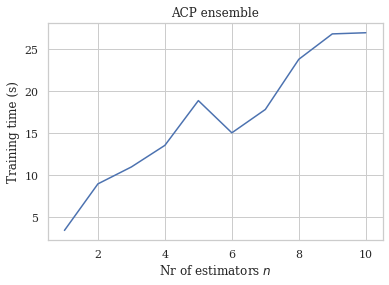

In [30]:
fig = plt.figure()
sns.lineplot(x="iter", y="time_train", data=df_acp)
plt.xlim(0.5, 10.5)
plt.ylabel("Training time (s)")
plt.xlabel("Nr of estimators $n$")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_training_time"))

plt.title("ACP ensemble")

plt.show()